In [1]:
import os
import numpy as np
import pandas as pd

from joblib import load
from tqdm.notebook import tqdm
from torch.utils import data

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output

import torch
from torch.utils import data

from src.Sparse_vector.sparse_vector import SparseVector
from src.data_preparation import get_train_test_dataset
from src.train_test import set_random_seed, train

In [2]:
features_weights = pd.read_csv("interpretation_files/features_importance_Kouzine.csv")

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f"z_dna/hg38_dna/") if f"{chrom}_" in i])
    return "".join([load(f"z_dna/hg38_dna/{file}") for file in files])


chroms = [f"chr{i}" for i in list(range(1, 23)) + ["X", "Y", "M"]]
all_features = [
    i[:-4] for i in os.listdir("z_dna/hg38_features/sparse/") if i.endswith(".pkl")
]
groups = ["DNase-seq", "Histone", "RNA polymerase", "TFs and others"]
top_count = 125
feature_names = features_weights.sort_values("borda_rank")["feature_names"].tolist()[
    :top_count
]


In [4]:
DNA = {chrom: chrom_reader(chrom) for chrom in tqdm(chroms)}

ZDNA_data = load("z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl")

DNA_features = {
    feature: load(f"z_dna/hg38_features/sparse/{feature}.pkl")
    for feature in tqdm(feature_names)
}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

CPU times: user 16.8 s, sys: 7.23 s, total: 24 s
Wall time: 33.9 s


In [5]:
np.random.seed(10)

width = 100

train_dataset, test_dataset = get_train_test_dataset(
    width, chroms, feature_names, DNA, DNA_features, ZDNA_data
)


100%|██████████| 165/165 [00:00<00:00, 6993.26it/s]


In [6]:
params = {"batch_size": 256, "num_workers": 5, "shuffle": True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)


In [7]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from IPython.display import clear_output


class ImageZ(nn.Module):
    def __init__(self, width, features_count):
        super().__init__()
        self.width = width
        self.features_count = features_count

        self.seq = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(2, 4),
            nn.Conv2d(4, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 8),
            nn.Conv2d(8, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 64),
            nn.Conv2d(64, 128, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.GroupNorm(32, 128),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(32, 64),
            nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),
            nn.Conv2d(32, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16),
            nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 8),
            nn.Conv2d(8, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 4),
            nn.Conv2d(4, 1, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(1, 1),
            nn.AlphaDropout(p=0.2),
            nn.Linear(features_count + 4, 500),
            nn.AlphaDropout(p=0.2),
            nn.SELU(),
            nn.Linear(500, 2),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, self.width, self.features_count + 4)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x


In [8]:
model = ImageZ(width, len(feature_names))
model= nn.DataParallel(model)
model = model.to("cuda")

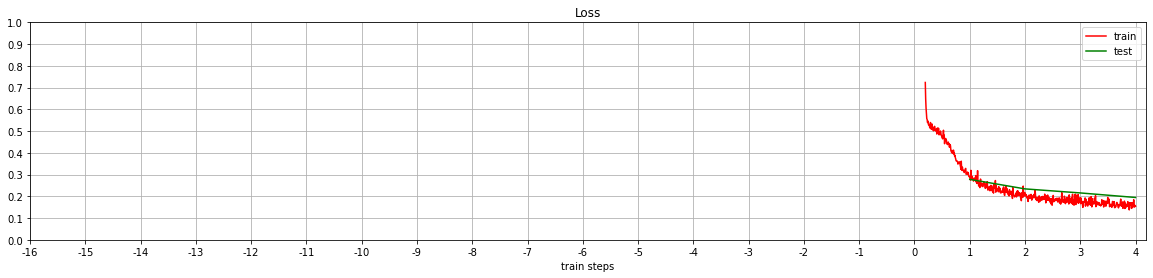

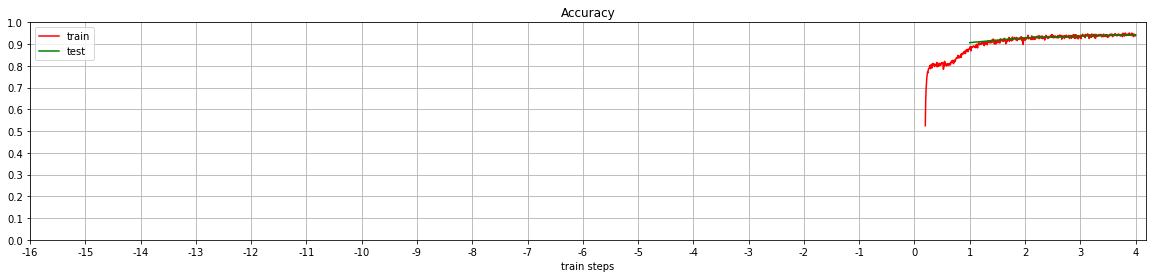

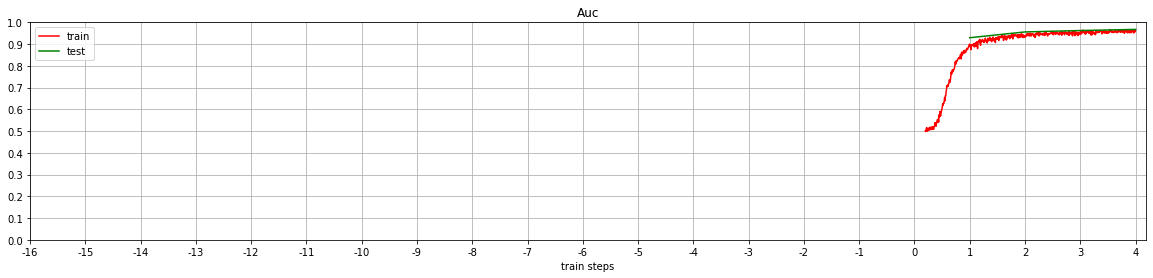

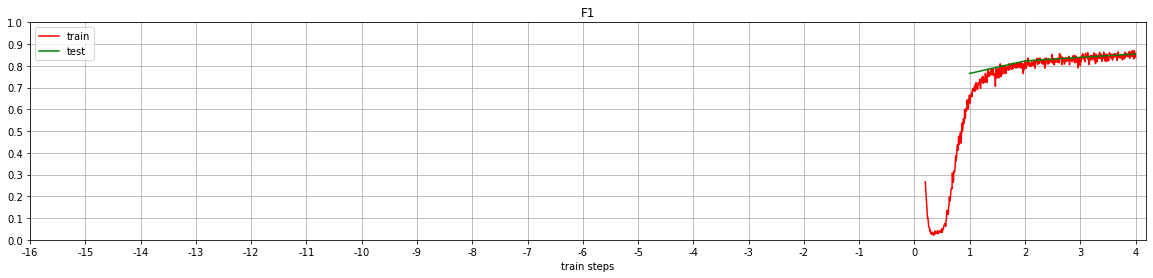

Time:  29123474.436633654
Epoch 4: ROC-AUC = 96.76%
Epoch 4: Precision = 0.839
Epoch 4: Recall = 0.871
Epoch 4: F1-score = 0.854


,epoch,AUC-ROC,F1-score,Precision,Recall
0,1,0.929333,0.765070,0.745090,0.786558
1,2,0.956005,0.822592,0.795432,0.851931
2,3,0.962423,0.839120,0.822485,0.856694
3,4,0.967586,0.854342,0.838582,0.870877


Final ROC-AUC = 96.76%
Final Precision = 0.839
Final Recall = 0.871
Final F1-score = 0.854


In [11]:
n_epochs = 4
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

(
    val_auc_log,
    val_pr_log,
    val_rec_log,
    val_f1_log,
    val_acc_log,
    val_loss_log,
    times,
    best_models,
) = train(model, opt, n_epochs, loader_train, loader_test)
